In [1]:
# prompt: Connect to my google drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import types
import sys

In [16]:
class FxNet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.n_classes = n_classes
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.batchNorm1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 12, 5)
        self.batchNorm2 = nn.BatchNorm2d(12)
        self.fc1 = nn.Linear(12*29*18, 120)
        self.batchNorm3 = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 60)
        self.batchNorm4 = nn.BatchNorm1d(60)
        self.out = nn.Linear(60, self.n_classes)

    def forward(self, t):
        t = self.conv1(t)
        t = self.batchNorm1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, 2, 2)
        t = self.conv2(t)
        t = self.batchNorm2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, 2, 2)
        t = t.view(-1, 12*29*18)
        t = self.fc1(t)
        t = self.batchNorm3(t)
        t = F.relu(t)
        t = self.fc2(t)
        t = self.batchNorm4(t)
        t = F.relu(t)
        t = self.out(t)
        return t

# Step 2: Dynamically create the module hierarchy: model.models.FxNet
model_module = types.ModuleType("model")
models_submodule = types.ModuleType("model.models")
setattr(models_submodule, "FxNet", FxNet)
setattr(model_module, "models", models_submodule)

# Step 3: Inject into sys.modules
sys.modules["model"] = model_module
sys.modules["model.models"] = models_submodule

# Step 4: Load model
# model_path = "/content/drive/MyDrive/PedalML/fx_classifier_models/20201219_fxnet_poly_disc_noTS9_best"
model_path = "/content/drive/MyDrive/PedalML/fx_classifier_models/20201027_fxnet_mono_disc_best"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fxnet_model = torch.load(model_path, map_location=device, weights_only=False)
fxnet_model.eval()


FxNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (batchNorm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (batchNorm2): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=6264, out_features=120, bias=True)
  (batchNorm3): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (batchNorm4): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out): Linear(in_features=60, out_features=13, bias=True)
)

In [17]:
# fxnet_model is already loaded and on the right device
torch.save(fxnet_model.state_dict(), "drive/MyDrive/PedalML/fxnet_mono_disc_best.pth")

In [48]:
import torch
import torch.nn as nn

# Define your LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)


    def forward(self, x, hidden=None):
        if hidden is None:
            batch_size = x.size(0)
            h_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=x.device)
            c_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=x.device)
            hidden = (h_0, c_0)

        out, hidden = self.lstm(x, hidden)  # out: (B, T, H)
        out = self.fc(out)                  # out: (B, T, 1)
        return out, hidden


In [30]:
import torchaudio
from torch.utils.data import Dataset, DataLoader

class GuitarEffectsDataset(Dataset):
    def __init__(self, clean_files, effect_files, sample_rate=44100, segment_length=1.0):
        assert len(clean_files) == len(effect_files), "Mismatched number of files"
        self.clean_files = clean_files
        self.effect_files = effect_files
        self.target_sr = sample_rate
        self.segment_samples = int(sample_rate * segment_length)  # e.g., 3s segment

    def __len__(self):
        return len(self.clean_files)

    def __getitem__(self, idx):
        # Load clean and effected audio
        clean_wave, sr_c = torchaudio.load(self.clean_files[idx])
        effect_wave, sr_e = torchaudio.load(self.effect_files[idx])
        # If stereo, take only one channel (assuming [channel, time] format from torchaudio)
        clean_wave = clean_wave.mean(dim=0, keepdim=True)  # shape [1, samples]
        effect_wave = effect_wave.mean(dim=0, keepdim=True)
        # Resample if needed to target sample rate
        if sr_c != self.target_sr:
            clean_wave = torchaudio.functional.resample(clean_wave, sr_c, self.target_sr)
        if sr_e != self.target_sr:
            effect_wave = torchaudio.functional.resample(effect_wave, sr_e, self.target_sr)
        # Pad or truncate to segment_samples
        # If too long, truncate; if too short, pad with zeros at end.
        if clean_wave.size(1) > self.segment_samples:
            clean_wave = clean_wave[:, :self.segment_samples]
            effect_wave = effect_wave[:, :self.segment_samples]
        else:
            pad_amount = self.segment_samples - clean_wave.size(1)
            if pad_amount > 0:
                clean_wave = F.pad(clean_wave, (0, pad_amount))
                effect_wave = F.pad(effect_wave, (0, pad_amount))
        # Return waveforms as tensors (shape [1, L]) and ensure dtype float32
        return clean_wave.float(), effect_wave.float()


In [31]:
# Get clean and effected guitar dataset
from os import listdir
from os.path import isfile, join
clean_file_path = "/content/drive/MyDrive/PedalML/Input/Input_Multiple_Notes"
clean_files = [join(clean_file_path, f) for f in listdir(clean_file_path) if isfile(join(clean_file_path, f))]
# Guitar Set
print(len(clean_files))
print(clean_files[:5])

effect_file_path = "/content/drive/MyDrive/PedalML/Target/distortion_reverb"
effect_files = [join(effect_file_path, f) for f in listdir(effect_file_path) if isfile(join(effect_file_path, f))]
# Guitar Set
print(len(effect_files))
print(effect_files[:5])

1
['/content/drive/MyDrive/PedalML/Input/Input_Multiple_Notes/00_BN1-147-Gb_comp_mix.wav']
1
['/content/drive/MyDrive/PedalML/Target/distortion_reverb/00_BN2-166-Ab_comp_mix_distortion_reverb.wav']


In [32]:
%pip install pydub

In [33]:
import os
from pydub import AudioSegment

def separate_audio(input_file, output_path, min_length=1.0):
    """
    Splits an audio file into segments of at least `min_length` seconds.

    Args:
        input_file (str): Path to the input audio file.
        output_path (str): Directory to save the output audio segments.
        min_length (float): Minimum length of each segment in seconds.
    """
    audio = AudioSegment.from_file(input_file)
    min_length_ms = int(min_length * 1000)  # pydub works with milliseconds
    total_length = len(audio)
    base_name = os.path.splitext(os.path.basename(input_file))[0]
    file_names = []

    os.makedirs(output_path, exist_ok=True)

    segment_count = 0
    for start_time in range(0, total_length, min_length_ms):
        end_time = min(start_time + min_length_ms, total_length)
        segment = audio[start_time:end_time]
        if len(segment) < min_length_ms:
            break  # Avoid final segment if it's too short

        output_file = os.path.join(output_path, f"{base_name}_part{segment_count + 1}.wav")
        segment.export(output_file, format="wav")
        file_names += [output_file]
        segment_count += 1

    print(f"Exported {segment_count} segments from {input_file}.")
    return file_names

In [34]:
separated_clean_files = []
for file in clean_files:
  separated_clean_files += separate_audio(file, "/content/drive/MyDrive/PedalML/Input/Train")
clean_files = separated_clean_files

separated_effect_files = []
for file in effect_files:
  separated_effect_files += separate_audio(file, "/content/drive/MyDrive/PedalML/Target/Train")
effect_files = separated_effect_files

Exported 19 segments from /content/drive/MyDrive/PedalML/Input/Input_Multiple_Notes/00_BN1-147-Gb_comp_mix.wav.
Exported 23 segments from /content/drive/MyDrive/PedalML/Target/distortion_reverb/00_BN2-166-Ab_comp_mix_distortion_reverb.wav.


In [35]:
print(clean_files[:3])
print(len(clean_files))

print(effect_files[:3])
print(len(effect_files))

['/content/drive/MyDrive/PedalML/Input/Train/00_BN1-147-Gb_comp_mix_part1.wav', '/content/drive/MyDrive/PedalML/Input/Train/00_BN1-147-Gb_comp_mix_part2.wav', '/content/drive/MyDrive/PedalML/Input/Train/00_BN1-147-Gb_comp_mix_part3.wav']
19
['/content/drive/MyDrive/PedalML/Target/Train/00_BN2-166-Ab_comp_mix_distortion_reverb_part1.wav', '/content/drive/MyDrive/PedalML/Target/Train/00_BN2-166-Ab_comp_mix_distortion_reverb_part2.wav', '/content/drive/MyDrive/PedalML/Target/Train/00_BN2-166-Ab_comp_mix_distortion_reverb_part3.wav']
23


In [36]:
def match_list_lengths(list1, list2):
    # Because we are expecting the embedding of the target audio to be the same,
    # Cartesian product of dataset only increases the complexity of the model.
    len1, len2 = len(list1), len(list2)
    if len1 == len2:
        return list1, list2
    elif len1 > len2:
        repeated_list2 = (list2 * (len1 // len2 + 1))[:len1]
        return list1, repeated_list2
    else:
        repeated_list1 = (list1 * (len2 // len1 + 1))[:len2]
        return repeated_list1, list2

# Repeat the shorter file to match the length of the longer file by repeating
clean_files, effect_files = match_list_lengths(clean_files, effect_files)
dataset = GuitarEffectsDataset(clean_files, effect_files, sample_rate=44100, segment_length=1.0)
loader = DataLoader(dataset, batch_size=1, shuffle=True)

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define a Mel-spectrogram transform (differentiable)
mel_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=44100,       # sample rate of audio
    n_fft=1024,             # FFT size
    hop_length=256,         # hop size for STFT
    n_mels=128              # number of Mel frequency bands
).to(device)

/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(


In [38]:
# fxnet_model = ...  # assume this is loaded with pre-trained weights
print(fxnet_model.eval())  # set to evaluation mode (not training it)
# Freeze parameters
for param in fxnet_model.parameters():
    param.requires_grad = False

# # Modify fxnet_model to easily get fc2 outputs.
# # This depends on fxnet_model's implementation.
# # If fxnet_model.fc3 is the final classification layer and fxnet_model.fc2 is the penultimate,
# # we can remove the final layer:
# if hasattr(fxnet_model, 'fc3'):
#     fxnet_model.fc3 = nn.Identity()
# # Now, fxnet_model(mel) will output whatever was previously the input to fc3 (i.e., fc2's output).


FxNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (batchNorm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (batchNorm2): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=6264, out_features=120, bias=True)
  (batchNorm3): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (batchNorm4): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out): Linear(in_features=60, out_features=12, bias=True)
)


In [39]:
import torch.nn.functional as F

# Pre-emphasis filter function
pre_emphasis_coef = 0.95 # As used in https://arxiv.org/pdf/1811.00334 and other previous works
def pre_emphasis(signal):
    # signal shape: (batch, samples) or (batch, 1, samples)
    # We will ensure it's 2D (batch, samples) for simplicity
    if signal.dim() == 3:
        # assume shape (batch, 1, L)
        signal = signal[:, 0, :]
    # Apply y[n] = x[n] - alpha * x[n-1]
    # Pad the beginning with zero for alignment (y[0] = x[0])
    y = signal.clone()
    y[:, 1:] = signal[:, 1:] - pre_emphasis_coef * signal[:, :-1]
    # y[:, 0] is left as signal[:,0] (we could also do y[:,0] = signal[:,0] for clarity)
    return y

Epoch 30/30 - Total Loss: 24.9577, Spectral: 0.0020, Embedding: 24.9558


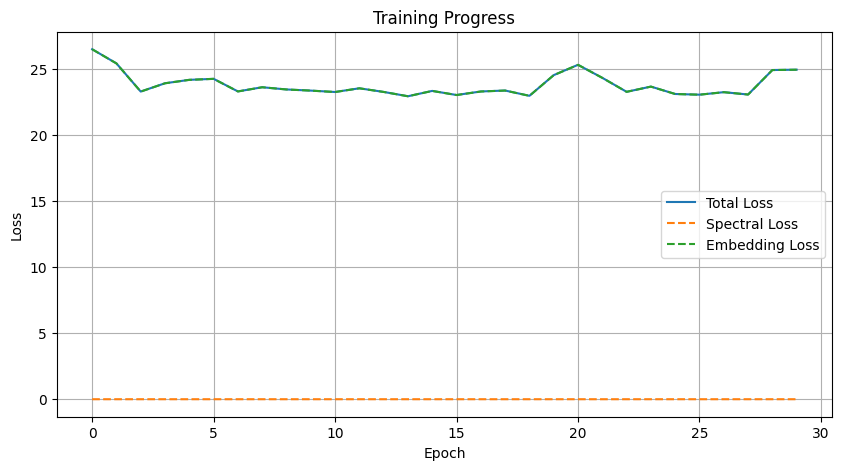

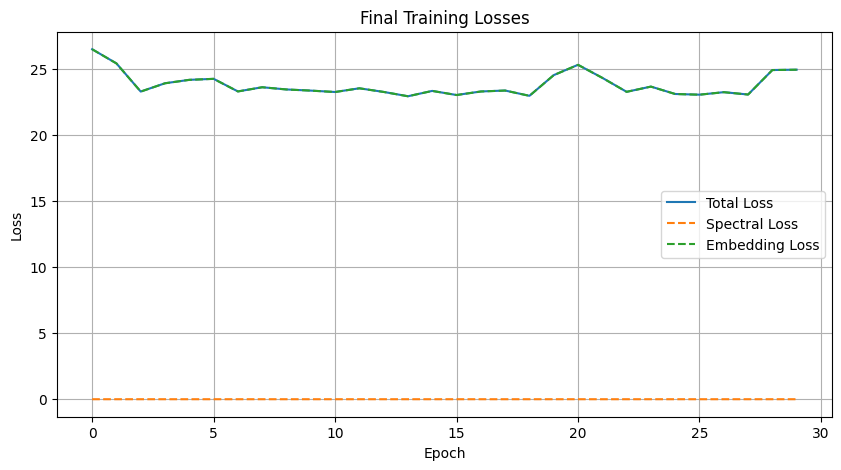

In [55]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Initialize model and optimizer
# model = WaveNetModel(residual_channels=32, skip_channels=32, dilation_layers=10)
model = LSTMModel(input_size=1, hidden_size=128, num_layers = 2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
fxnet_model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model.train()
num_epochs = 30

# Lists to track loss
epoch_losses = []
spectral_losses = []
embedding_losses = []

for epoch in range(num_epochs):
    total_loss, total_spectral, total_embedding = 0.0, 0.0, 0.0

    for clean_wave, target_wave in loader:
        clean_wave = clean_wave.to(device)
        target_wave = target_wave.to(device)

        # Forward pass
        clean_wave = clean_wave.transpose(1, 2) # Due to LSTM should look like (B, T, 1)
        output_wave, _ = model(clean_wave)
        output_wave = output_wave.transpose(1, 2)  # LSTM output shape: (B, T, 1) → (B, 1, T)

        # Spectral loss (pre-emphasized MSE)
        clean_pre = pre_emphasis(clean_wave)
        output_pre = pre_emphasis(output_wave)
        spectral_loss = F.mse_loss(output_pre, clean_pre)

        # Embedding loss (MAE in fxnet_model feature space)
        mel_target = mel_transform(target_wave)
        mel_output = mel_transform(output_wave)

        if mel_target.dim() == 3:
            mel_target = mel_target.unsqueeze(1)
            mel_output = mel_output.unsqueeze(1)



        # Interpolate for 3 times
        mel_target = mel_target.repeat(1, 1, 1, 3)
        mel_output = mel_output.repeat(1, 1, 1, 3)




        with torch.no_grad():  # fxnet_model is frozen, no gradients needed
            emb_target = fxnet_model(mel_target)

        emb_output = fxnet_model(mel_output)
        embedding_loss = F.l1_loss(emb_output, emb_target)

        # Total loss
        loss = spectral_loss + embedding_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_spectral += spectral_loss.item()
        total_embedding += embedding_loss.item()

    # Average losses
    avg_loss = total_loss / len(loader)
    avg_spectral = total_spectral / len(loader)
    avg_embedding = total_embedding / len(loader)

    epoch_losses.append(avg_loss)
    spectral_losses.append(avg_spectral)
    embedding_losses.append(avg_embedding)

    clear_output(wait=True)
    print(f"Epoch {epoch+1}/{num_epochs} - Total Loss: {avg_loss:.4f}, "
          f"Spectral: {avg_spectral:.4f}, Embedding: {avg_embedding:.4f}")

    # Intermediate visualization every 5 epochs
    if (epoch + 1) % 5 == 0 or epoch == num_epochs - 1:
        plt.figure(figsize=(10, 5))
        plt.plot(epoch_losses, label='Total Loss')
        plt.plot(spectral_losses, label='Spectral Loss', linestyle='--')
        plt.plot(embedding_losses, label='Embedding Loss', linestyle='--')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Progress')
        plt.legend()
        plt.grid()
        plt.show()

# Final results
plt.figure(figsize=(10, 5))
plt.plot(epoch_losses, label='Total Loss')
plt.plot(spectral_losses, label='Spectral Loss', linestyle='--')
plt.plot(embedding_losses, label='Embedding Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Final Training Losses')
plt.legend()
plt.grid()
plt.show()


In [63]:
save_path = "/content/drive/MyDrive/PedalML/models/lstm_model_250420.pth"
torch.save(model.state_dict(), save_path)

In [ ]:
# Recreate model with same architecture
# load_path = "/content/drive/MyDrive/PedalML/models/wavenet_model_250419.pth"
# model = WaveNetModel(residual_channels=32, skip_channels=32, dilation_layers=10)
# model.load_state_dict(torch.load("wavenet_model.pth", map_location=device))
# model.to(device)
# model.eval()

In [ ]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)
# fxnet_model.to(device)

# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# model.train()
# num_epochs = 30

# # Lists to track loss
# epoch_losses = []
# spectral_losses = []
# embedding_losses = []

# for epoch in range(num_epochs):
#     total_loss, total_spectral, total_embedding = 0.0, 0.0, 0.0

#     for clean_wave, target_wave in loader:
#         clean_wave = clean_wave.to(device)
#         target_wave = target_wave.to(device)

#         # Forward pass
#         output_wave = model(clean_wave)

#         # Spectral loss (pre-emphasized MSE)
#         clean_pre = pre_emphasis(clean_wave)
#         output_pre = pre_emphasis(output_wave)
#         spectral_loss = F.mse_loss(output_pre, clean_pre)

#         # Embedding loss (MAE in fxnet_model feature space)
#         mel_target = mel_transform(target_wave)
#         mel_output = mel_transform(output_wave)

#         if mel_target.dim() == 3:
#             mel_target = mel_target.unsqueeze(1)
#             mel_output = mel_output.unsqueeze(1)

#         with torch.no_grad():  # fxnet_model is frozen, no gradients needed
#             emb_target = fxnet_model(mel_target)

#         emb_output = fxnet_model(mel_output)
#         embedding_loss = F.l1_loss(emb_output, emb_target)

#         # Total loss
#         loss = spectral_loss + embedding_loss

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()
#         total_spectral += spectral_loss.item()
#         total_embedding += embedding_loss.item()

#     # Average losses
#     avg_loss = total_loss / len(loader)
#     avg_spectral = total_spectral / len(loader)
#     avg_embedding = total_embedding / len(loader)

#     epoch_losses.append(avg_loss)
#     spectral_losses.append(avg_spectral)
#     embedding_losses.append(avg_embedding)

#     clear_output(wait=True)
#     print(f"Epoch {epoch+1}/{num_epochs} - Total Loss: {avg_loss:.4f}, "
#           f"Spectral: {avg_spectral:.4f}, Embedding: {avg_embedding:.4f}")

#     # Intermediate visualization every 5 epochs
#     if (epoch + 1) % 5 == 0 or epoch == num_epochs - 1:
#         plt.figure(figsize=(10, 5))
#         plt.plot(epoch_losses, label='Total Loss')
#         plt.plot(spectral_losses, label='Spectral Loss', linestyle='--')
#         plt.plot(embedding_losses, label='Embedding Loss', linestyle='--')
#         plt.xlabel('Epoch')
#         plt.ylabel('Loss')
#         plt.title('Training Progress')
#         plt.legend()
#         plt.grid()
#         plt.show()

# # Final results
# plt.figure(figsize=(10, 5))
# plt.plot(epoch_losses, label='Total Loss')
# plt.plot(spectral_losses, label='Spectral Loss', linestyle='--')
# plt.plot(embedding_losses, label='Embedding Loss', linestyle='--')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Final Training Losses')
# plt.legend()
# plt.grid()
# plt.show()


In [56]:
# import torch
# import torchaudio
# import torchaudio.transforms as T

# model.to(device)
# model.eval()

# # Load audio file
# def load_audio(file_path, target_sr=44100):
#     waveform, sample_rate = torchaudio.load(file_path)
#     if sample_rate != target_sr:
#         resampler = T.Resample(sample_rate, target_sr)
#         waveform = resampler(waveform)
#     return waveform.to(device)

# # Save audio file
# def save_audio(file_path, waveform, sample_rate=44100):
#     waveform_cpu = waveform.cpu().detach()
#     torchaudio.save(file_path, waveform_cpu, sample_rate)

# # Run inference on audio file
# def process_audio(input_path, output_path):
#     with torch.no_grad():
#         input_wave = load_audio(input_path)  # shape: [1, L]
#         input_wave = input_wave.unsqueeze(0)  # add batch dimension [1, 1, L]

#         # Generate processed audio
#         output_wave = model(input_wave)

#         # Remove batch dimension
#         output_wave = output_wave.squeeze(0)

#         # Save output
#         save_audio(output_path, output_wave)

# # Example usage:
# input_audio_file = "/content/drive/MyDrive/PedalML/Test/test.wav"
# output_audio_file = "/content/drive/MyDrive/PedalML/Test/result.wav"

# process_audio(input_audio_file, output_audio_file)

# print(f"Audio processed and saved as '{output_audio_file}'.")


In [57]:
input_audio_file = "/content/drive/MyDrive/PedalML/Test/test.wav"
output_audio_file = "/content/drive/MyDrive/PedalML/Test/result.wav"
waveform = load_audio(input_audio_file)

# Process audio
processed_waveform = process_audio_in_chunks(model, waveform, chunk_size=2048, device='cuda')

# Save output audio
save_audio(output_audio_file, processed_waveform)

NameError: name 'load_audio' is not defined

In [65]:
import torch
import torchaudio
import torch.nn.functional as F

def infer_in_chunks(model, waveform, chunk_size=2048, device='cuda'):
    model.eval()
    model.to(device)
    waveform = waveform.to(device)  # [1, T]

    # Ensure shape is (B, T)
    if waveform.dim() == 2:
        pass
    elif waveform.dim() == 1:
        waveform = waveform.unsqueeze(0)
    else:
        raise ValueError("Expected waveform shape (B, T) or (T,)")

    # Pad to make divisible by chunk_size
    total_length = waveform.size(1)
    pad_length = (chunk_size - total_length % chunk_size) % chunk_size
    if pad_length > 0:
        waveform = F.pad(waveform, (0, pad_length))

    num_chunks = waveform.size(1) // chunk_size
    outputs = []
    hidden = None

    with torch.no_grad():
        for i in range(num_chunks):
            chunk = waveform[:, i * chunk_size : (i + 1) * chunk_size]  # [1, chunk_size]
            chunk = chunk.unsqueeze(-1)  # [1, chunk_size, 1] for LSTM
            output, hidden = model(chunk, hidden)  # Stateful inference
            outputs.append(output.squeeze(-1))  # [1, chunk_size]

    output_waveform = torch.cat(outputs, dim=1)  # [1, total_samples]

    # Normalize the sound
    output_waveform = output_waveform / output_waveform.abs().max()
    return output_waveform[:, :total_length]  # remove pad if any


In [66]:
# # Load model
# model = LSTMModel(input_size=1, hidden_size=128, num_layers=2)
# model.load_state_dict(torch.load("lstm_model.pth"))
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_audio_file = "/content/drive/MyDrive/PedalML/Test/test.wav"
output_audio_file = "/content/drive/MyDrive/PedalML/Test/result.wav"

# Load audio
waveform, sr = torchaudio.load(input_audio_file)  # waveform: [1, T]

# Infer
output = infer_in_chunks(model, waveform, chunk_size=2048, device=device)

# Save output
torchaudio.save(output_audio_file, output.cpu(), sr)